# Esport predictions: Overwatch League 

We study a single season of games in the professional esports league for Overwatch and try to predict game outcomes based on past performance.

Authors:

* Markus Hauru
* Tim Powell
* Kevin Xu

Reviewers:

* Aoife Hughes
* Jack Roberts


## Overwatch League (OWL)

Overwatch is an online team-based multiplayer first-person shooter (FPS) game developed and published by Blizzard Entertainment. It features different modes designed around combat between two opposing teams of six players each. It was first released in 2016 and has been highly popular among casual players, selling over 50 million copies, and as a professional esport.

Matches between two teams consist of several games and each game is played on one of 21 possible maps. There are four different types of maps with varying objectives, such as controlling key locations on the map or capturing them from the opponent. Each match includes games with different map types, and typically the losing team gets to choose the next map. An individual game may further subdivide into rounds, depending on the map type. A game ends in a victory for one of the two teams or a draw.

The Overwatch League (OWL) is the highest professional esports league for Overwatch, and is owned and run by Blizzard Entertainment. The 2021 OWL featured four midseason tournaments throughout the regular season which used a point system for season playoff seeding. OWL 2021 consisted of 20 teams split into two geographical regions: North America (NA) and Asia (APAC).



## Data Story

This Data Story will look at the data produced during the OWL 2021 season to determine whether it is possible to predict the result of a game between two teams. We started writing this story mid way through the OWL 2022 season and thus chose to use the OWL 2021 dataset because of its comprehensivity. Since then, OWL 2022 has concluded and a sequel - Overwatch 2 - has been released. We hope and believe this analysis will carry through to the new game given the great similarity between them.

One of our co-authors - Tim Powell - proposed this data story, stating:
"As I follow the OWL, I knew that it was possible to obtain the OWL data. I was curious to understand how much external, non-tangible factors influence the outcome of matches, and whether the historic data can tell the same story as to what happened in reality. The main question this data story aims to answer is:

* *Is it possible to use a team's historic data to predict their future performance?*"

## Outline

The story divides into the following parts.

[Part 1. Data Ingestion](#scrollTo=y4Cnt1XoDTVF&line=2&uniqifier=1)
  - Getting the source data

[Part 2. Data Cleaning](#scrollTo=7rhbsSHoHlSn&line=1&uniqifier=1)
  - Refining and filtering the data to the scope of our analysis

[Part 3. Initial data exploration](#scrollTo=wb_NCIQJI9xz&line=1&uniqifier=1)
  - Teams' win rates per map
  - Visualisation
  - Teams' records against each other per map

[Part 4. A benchmark predictor](#scrollTo=JupHOOJ1NUUF&line=1&uniqifier=1)
  - The pure guess predictor
  - A framework for training and testing models

[Part 5. Higher win rate predictor](#scrollTo=KGjg51ytQvQv&line=1&uniqifier=1)
  - Predicting winners based on past history on the given map

[Part 6. Skill based predictor - Elo ratings](#scrollTo=wWxuO8QtkTu9&line=3&uniqifier=1)
  - The Elo rating system
  - Predicting winners based on Elo ratings
  - Combining Elo ratings and map win rates for better predictions?

[Part 7. Conclusions](https://colab.research.google.com/drive/1niVhOprEyj1moSCP-AV9FKTXX5eA6Ge8#scrollTo=VLM2RBNc2jJ1&line=1&uniqifier=1)
  - What we learned
  - What we would like to do in the future

# Part 1. Data Ingestion

### Data source

We initially considered using a community made API to access the data. However, all such projects that we found seemed to be inactive. For example, the most popular community made API was https://github.com/acupoftee/Overwatch-League-API-Documentation which appears to have been abandoned (3 years since the last GitHub update). Other community made APIs were also abandoned around the same time period. This coincides with a move from hosting OWL on Twitch to Youtube.

Instead, we went straight to the raw source data. The official OWL website includes a stats tab that contains various data on players, heroes and matches. For this analysis, we will be using the [match data](https://overwatchleague.com/en-us/statslab) as it includes the results of match ups between different teams in the league.


### Ingestion

In [ ]:
import io
import itertools
import random
import requests
from zipfile import ZipFile

from IPython.display import clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import svm, linear_model, preprocessing

We start by importing all packages we'll need in the whole story. This includes some standard Python libraries to do the following:
- data manipulation (pandas, numpy)
- data extraction (zipfile, requests)
- data visualisation (pyplot, seaborn)
- machine learning and statistical modelling (sklearn) 
- notebook widgets (widgets, IPython.display)
- utilities (io, itertools, random)

In [ ]:
# Download zip file and unzip
url = "https://assets.blz-contentstack.com/v3/assets/blt321317473c90505c/bltb4a6fe3cc2efaa02/634732b68cdace44d7b8efc4/2022_Week24_match_map_stats.zip"
r = requests.get(url)
with ZipFile(io.BytesIO(r.content)) as z:
    first_file = z.namelist()[0]
    with z.open(first_file) as f:
        content = f.read()

We start by downloading a zip file containing all of the match and maps data over the last few years, and then ingest this as a pandas dataframe.

In [ ]:
# Convert files to csv and a pandas dataframe
data = io.StringIO(str(content, "utf-8"))
df = pd.read_csv(data)
df.head()

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score
0,01/11/18 00:12,01/11/18 00:20,2018: Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,Los Angeles Valiant,San Francisco Shock,75.61505,0.00000,0.000000,240.000,NaN,NaN,2,0
1,01/11/18 00:22,01/11/18 00:27,2018: Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,Los Angeles Valiant,San Francisco Shock,75.64960,75.61505,125.750570,0.000,NaN,NaN,3,2
2,01/11/18 00:34,01/11/18 00:38,2018: Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,Los Angeles Valiant,San Francisco Shock,0.00000,0.00000,250.492000,240.000,NaN,NaN,2,0
3,01/11/18 00:40,01/11/18 00:44,2018: Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,Los Angeles Valiant,San Francisco Shock,0.00000,0.00000,225.789030,250.492,NaN,NaN,2,2
4,01/11/18 00:46,01/11/18 00:49,2018: Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,Los Angeles Valiant,San Francisco Shock,0.00000,0.00000,36.396057,250.492,NaN,NaN,4,2


Here's what the data looks like, with some example rows from the top of the dataframe.


# Part 2. Data Cleaning

Next we reduce the data to only the information that we need.



Let's start with the 'Stage' column, allowing us to filter based on the Overwatch season. 

In [ ]:
df["stage"].unique()

array(['2018: Stage 1', '2018: Stage 1 Title Matches', '2018: Stage 2',
       '2018: Stage 2 Title Matches', '2018: Stage 3',
       '2018: Stage 3 Title Matches', '2018: Stage 4',
       '2018: Stage 4 Title Matches', '2018: Championship',
       '2019: Stage 1', '2019: Stage 1 Title Matches', '2019: Stage 2',
       '2019: Stage 2 Title Matches', '2019: Stage 3',
       '2019: Stage 3 Title Matches', '2019: Stage 4',
       '2019: Postseason Play-in', '2019: Playoffs & Grand Finals',
       '2020: Regular Season', '2020: May Melee: North America Knockouts',
       '2020: May Melee: Asia', '2020: May Melee: North America',
       '2020: Summer Showdown: North America Knockouts',
       '2020: Summer Showdown: Asia',
       '2020: Summer Showdown: North America',
       '2020: Countdown Cup: North America Knockouts',
       '2020: Countdown Cup: Asia', '2020: Countdown Cup: North America',
       '2020: North America Playoffs', '2020: Asia Playoffs',
       '2020: Grand Finals', '2021

For this analysis we're going to use the 2021 season, as it was the most recent, complete data set at the time of writing. Focussing on a single season is useful to avoid having to think too much about changes in team rosters: typically players remain in a team for the entire season, but between seasons many players move teams. Trying to analyse the effect of such transfers would be very interesting, but with limited time, we focus on the team-level analysis, and thus constrain ourselves to a single season.

The columns of the dataframe include plenty of information we don't care about: Recall that each match subdivides into games, which subdivide into rounds. We will keep our analysis on the level of games (which are always played on a single map), and thus can leave out all information about who won the match, or about the individual round, such as how far the payload (an object fought over on some map types) progressed.

In the end we are left with the following columns of interest, filtered to just the 2021 season.

In [ ]:
# Reduce data to only the OWL 2021 stage and only the relevant columns
kept_columns = [
    "match_id",
    "map_winner",
    "map_loser",
    "team_one_name",
    "team_two_name",
    "map_name",
    "round_start_time",
]
# We also encourage the reader to modify the string to run the analysis on a 
# different year.
owl21_reduced = df.loc[df["stage"].str.contains("2021"), kept_columns] 
owl21_reduced

,match_id,map_winner,map_loser,team_one_name,team_two_name,map_name,round_start_time
9071,37234,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,Busan,04/16/21 19:08
9072,37234,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,Busan,04/16/21 19:12
9073,37234,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,Busan,04/16/21 19:18
9074,37234,Dallas Fuel,Houston Outlaws,Houston Outlaws,Dallas Fuel,King's Row,04/16/21 19:30
9075,37234,Dallas Fuel,Houston Outlaws,Houston Outlaws,Dallas Fuel,King's Row,04/16/21 19:39
...,...,...,...,...,...,...,...
11220,37441,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,King's Row,09/26/21 01:57
11221,37441,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,King's Row,09/26/21 02:05
11222,37441,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,King's Row,09/26/21 02:09
11223,37441,Shanghai Dragons,Atlanta Reign,Shanghai Dragons,Atlanta Reign,Havana,09/26/21 02:53


For the purpose of this analysis round start times are not required except for the purpose of sorting the rounds to be chronologically ordeded. Note also that there are multiple rows for each map, because typically multiple rounds are played in each map. Additionally, as we are only considering game level results, round results are removed from the data. We then reset the index to have continuous numbering of the games starting from 0.

In [ ]:
owl21_reduced = owl21_reduced.sort_values("round_start_time")
kept_columns = [
    "match_id",
    "map_winner",
    "map_loser",
    "team_one_name",
    "team_two_name",
    "map_name",
]
owl21_reduced = (
    owl21_reduced[kept_columns].drop_duplicates().reset_index().drop(columns="index")
)
owl21_reduced

,match_id,map_winner,map_loser,team_one_name,team_two_name,map_name
0,37234,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,Busan
1,37234,Dallas Fuel,Houston Outlaws,Houston Outlaws,Dallas Fuel,King's Row
2,37234,Houston Outlaws,Dallas Fuel,Dallas Fuel,Houston Outlaws,Havana
3,37234,Dallas Fuel,Houston Outlaws,Houston Outlaws,Dallas Fuel,Volskaya Industries
4,37234,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,Ilios
...,...,...,...,...,...,...
889,37442,Atlanta Reign,Dallas Fuel,Dallas Fuel,Atlanta Reign,Dorado
890,37441,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,Ilios
891,37441,Shanghai Dragons,Atlanta Reign,Shanghai Dragons,Atlanta Reign,Hanamura
892,37441,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,King's Row


We are left with a data set of 894 games to study.

# Part 3. Initial data exploration

Our eventual goal is to predict the outcomes of future games based on past history of the teams involved. For example, a predictor should be able to use information from the first 200 maps to predict the result of the 201st map.

Before we do that however, let's start with exploring the data to get an initial idea of what it looks like and how teams perform. We start by collecting lists of all maps and teams.

In [ ]:
# Get list of maps
map_list = owl21_reduced["map_name"].unique()
map_list

array(['Busan', "King's Row", 'Havana', 'Volskaya Industries', 'Ilios',
       'Eichenwalde', 'Watchpoint: Gibraltar', 'Hanamura',
       'Lijiang Tower', 'Blizzard World', 'Dorado', 'Temple of Anubis',
       'Oasis', 'Nepal', 'Numbani', 'Rialto', 'Hollywood', 'Junkertown',
       'Route 66'], dtype=object)

In [ ]:
# Get list of teams
team_winners = owl21_reduced["map_winner"].unique()
team_losers = owl21_reduced["map_loser"].unique()
team_names = list(set().union(team_winners, team_losers))
team_names.remove("draw")
team_names

['Los Angeles Valiant',
 'Paris Eternal',
 'Shanghai Dragons',
 'London Spitfire',
 'San Francisco Shock',
 'Dallas Fuel',
 'Guangzhou Charge',
 'Washington Justice',
 'Los Angeles Gladiators',
 'New York Excelsior',
 'Atlanta Reign',
 'Vancouver Titans',
 'Florida Mayhem',
 'Chengdu Hunters',
 'Houston Outlaws',
 'Seoul Dynasty',
 'Toronto Defiant',
 'Boston Uprising',
 'Hangzhou Spark',
 'Philadelphia Fusion']

To get an idea of the performance of various teams, we compute their win rate for each map: The number of times they've won on that map, divided by the number of times they've played the map.

In [ ]:
def map_data(team_list, map_list, df):
    # make dataframe
    column_names = ("team_name", "map", "win_%", "win", "draw", "lose")
    team_map_data_df = pd.DataFrame(columns=column_names)

    # iterate through teams
    for team in team_list:
        # iterate through maps
        for map in map_list:
            # filter to specific team and map
            map_filter = df["map_name"] == map
            team_filter = (df["team_one_name"] == team) | (df["team_two_name"] == team)
            team_map_df = df[map_filter & team_filter]

            # calculate data and add to list
            num_win = (team_map_df.map_winner == team).sum()
            num_lose = (team_map_df.map_loser == team).sum()
            num_total = len(team_map_df.index)
            num_draw = num_total - num_win - num_lose
            win_perc = num_win / num_total if num_total > 0 else np.nan
            map_data_list = [team, map, round(win_perc, 4), num_win, num_draw, num_lose]

            # append data list to dataframe
            team_map_data_df.loc[len(team_map_data_df)] = map_data_list

    team_map_data_df["games_played"] = team_map_data_df[["win", "draw", "lose"]].sum(
        axis=1
    )
    return team_map_data_df


all_teams_map_data = map_data(team_names, map_list, owl21_reduced)
all_teams_map_data

,team_name,map,win_%,win,draw,lose,games_played
0,Los Angeles Valiant,Busan,0.0000,0,0,2,2.0
1,Los Angeles Valiant,King's Row,0.3333,1,0,2,3.0
2,Los Angeles Valiant,Havana,0.0000,0,0,2,2.0
3,Los Angeles Valiant,Volskaya Industries,0.0000,0,1,4,5.0
4,Los Angeles Valiant,Ilios,0.0000,0,0,4,4.0
...,...,...,...,...,...,...,...
375,Philadelphia Fusion,Numbani,0.6000,3,0,2,5.0
376,Philadelphia Fusion,Rialto,0.7500,3,0,1,4.0
377,Philadelphia Fusion,Hollywood,1.0000,2,0,0,2.0
378,Philadelphia Fusion,Junkertown,0.3333,1,0,2,3.0


Let's see what the distribution of win rates looks like over maps and teams. The win rate isn't very meaningful if the team has only played the map a handful of times, so we also set a cut-off, where we only consider team-map combinations that occur at least 4 times during the season

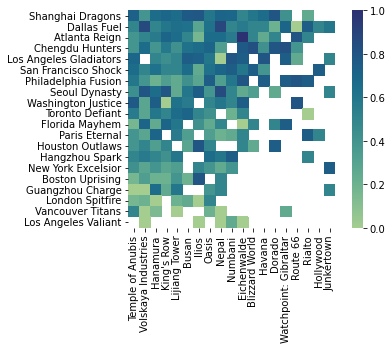

In [ ]:
def plot_win_rate_distribution(owl21_reduced, all_teams_map_data, min_games=4):
    filtered_all_teams_map_data = all_teams_map_data.copy()
    filtered_all_teams_map_data["win_%"] = filtered_all_teams_map_data["win_%"].where(
        all_teams_map_data["games_played"] >= min_games, np.nan
    )
    # Visualise win rates of teams vs maps
    team_map_matrix = filtered_all_teams_map_data.set_index("team_name").pivot(
        columns="map"
    )["win_%"]
    # Sort teams by total wins and maps by total match count.
    team_order = owl21_reduced["map_winner"].value_counts().argsort().drop("draw")
    map_order = owl21_reduced["map_name"].value_counts().argsort()
    team_map_matrix = team_map_matrix.loc[team_order.index, map_order.index]
    sns.heatmap(team_map_matrix, vmin=0, vmax=1, square=True, cmap="crest")


plot_win_rate_distribution(owl21_reduced, all_teams_map_data)

On the vertical axis here are the teams, ordered by total number of wins over the season. On the horizontal axis are maps, ordered by how many times they were played during the season. The colours code the win rates.

Some observations:
* Due to the season being quite short, there are many teams that didn't play certain maps more than 4 times. This also varies between teams, because the good teams get to play more matches, and thus have less maps for which they have little data. This lack of data will cause us problems later.
* The good teams seem to be good on almost all maps, the bad teams are bad on almost all maps. This suggests that there is not much map specialisation.
* There are some exceptions to the above point. E.g. Dallas Fuel is the second best team by total win count, but has a very low win rate on Route 66. Conversely, Boston Uprising is one of the worst teams, but has a very good record on Ilios.
* Some maps are much more popular than others. Almost all teams have played more than 4 game on Temple of Anubis, Volskaya Industries, and Hanamura, where as only three teams have more than 4 games on Hollywood.

In [ ]:
out = widgets.Output()


def on_team_selection(change):
    with out:
        clear_output()
        team = team_selector.value
        team_filter = all_teams_map_data["team_name"] == change["new"]
        print(all_teams_map_data[team_filter].to_string(index=False))


team_selector = widgets.Dropdown(
    options=team_names, value=None, description="Team Name"
)
display(team_selector)
display(out)
team_selector.observe(on_team_selection, names="value")

Dropdown(description='Team Name', options=('Los Angeles Valiant', 'Paris Eternal', 'Shanghai Dragons', 'London…

Output()

If you're curious about a particular team's performance, you can use the above widget to browse how they did on each map.

# Part 4. A benchmark predictor

Our goal is to create various predictors - models that can take in historical data to predict the result of a future map. 

To assess the performance of our models fairly we split our dataset into training and test sets. We choose an unusually large fraction, 50% of our data, to be the test set. This is because our models will require very little training, as we will see.

We considered using a separate validation set as well, that wouldn't be used when comparing various models, but only used to check the final performance of our chosen best model at the very end. This would guard against overfitting in model selection and hyperparameter tuning. However, since we'll be doing very little hyperparameter tuning, and will only deal with a handful of simple models, we chose against it. This helps make the most of our quite small data set.

In addition to guarding against overfitting as usual, the train/test split serves another purpose for us: our data is time series data, and our goal is to predict games late in the season, based on what we learned earlier in the season. By testing all our models on the test set that is the latter half of the season we ensure we don't do something silly, like try to "predict" the first games based on what we learned from the last ones.

In [ ]:
# Set up test-training datasets.
test_fraction = 0.5
train_fraction = 1 - test_fraction
n_games = len(owl21_reduced)
n_train = int(np.round(n_games * train_fraction))
train_data = owl21_reduced.iloc[:n_train, :]
test_data = owl21_reduced.iloc[n_train:, :]
n_test = len(test_data)

### Framework for evaluating predictors

We also set up a framework for evaluating different models and for defining predictors. This helps to reduce code duplication, and gives a neat interface for testing model performance.

In [ ]:
def _get_model_rate(model, actual_winners, predictors):
    predicted_results = model.predict(predictors)
    predicted_winners = predicted_results.loc[:, "map_winner"]
    correct_predictions = (predicted_winners == actual_winners).sum()
    rate = correct_predictions / len(actual_winners)
    return rate


def train_and_test(train_data, test_data, model_class, *args, **kwargs):
    """Train and test a model of a given class.

    The `model_class` argument should be a class with two methods with signatures
    `train(self, train_data)` and `predict(self, predictors)`. `train` should return
    `None` and modify the model object in-place to do the training.  `predict` should
    return a DataFrame with the same index as `predictors`, and with a column
    `"map_winner"` that includes the predictions for each game's winner.

    Args:
      train_data: Training dataset.
      test_data: Test dataset to test model performance on.
      model_class: A class with `train` and `predict` methods as described above.
      *args, **kwargs: Additional arguments are passed to the constructor of
        `model_class`. These could be e.g. parameters for the model

    Returns:
      A dictionary with the following keys:
      test_rate: The proportion of games the model predicted correctly in the test set.
      train_rate: The proportion of games the model predicted correctly in the training
          set.
      model: The trained model.
    """
    model = model_class(*args, **kwargs)
    model.train(train_data)
    test_predictors = test_data.drop(
        columns=["map_winner", "map_loser"],
        errors="ignore",
    )
    test_winners = test_data.loc[:, "map_winner"]
    test_rate = _get_model_rate(model, test_winners, test_predictors)
    train_predictors = train_data.drop(
        columns=["map_winner", "map_loser"],
        errors="ignore",
    )
    train_winners = train_data.loc[:, "map_winner"]
    train_rate = _get_model_rate(model, train_winners, train_predictors)
    return {"test rate": test_rate, "train rate": train_rate, "model": model}

### Guessing predictors

To get a sense of how good our predictors are, it is useful to first develop a benchmark predictor. We start with the simplest predictor imaginable: random guessing. We should expect that our actual models will be much more accurate than this one, and that something is going wrong if they are not.

Given that we know the result of each map can either be a 'team 1 wins', 'team 2 wins', or 'draw', we can create a benchmark predictor that simply selects one of the above at random as the result of each map.

In [ ]:
class PureRandomModel:
    """A model class that predicts the outcome of a game purely at random."""

    def train(self, train_data):
        """training does nothing as it is all random!"""
        return None

    def _random_predictions(self, team_one, team_two, map_name):
        choices = [team_one, team_two, "draw"]
        victor = random.choice(choices)
        return victor

    def predict(self, predictors):
        """Guess the outcome at random."""
        predictors["map_winner"] = predictors.apply(
            lambda x: self._random_predictions(
                x["team_one_name"], x["team_two_name"], x["map_name"]
            ),
            axis=1,
        )
        return predictors

In [ ]:
train_and_test(train_data, test_data, PureRandomModel)

{'test rate': 0.3169642857142857,
 'train rate': 0.3378076062639821,
 'model': <__main__.PureRandomModel at 0x7f920343eb80>}

Try running the above cell a few times - you'll find that the accuracy for the test and training data seems to fluctuate a lot. This is because each time we run the cell, our model guesses randomly, and the dataset isn't quite large enough for the law of large numbers to kick in with force.

The main thing to note is how inaccurate the guessing model is. This is because the pure random distribition is unrealistic - very few games are actually drawn meaning a predictor that guesses a draw 1 in 3 times does not really come close. We retrospectively know that only around 2% of maps were drawn in the 2021 season.

We could improve on this by randomly picking between team 1 or team 2 winning, and never predict a draw, although this requires prior knowledge about Overwatch which we were trying to avoid with our simplest imaginable predictor. We could also count the actual proportion of draws in the data and weigh the probabilities proportionally, but this would use future knowledge: the predictor would somehow be using knowledge that there are, say 10 draws by the end of season, to predict whether a match in the middle of the season is a draw. Alternatively we could use the proportion of draws in the previous season.

For brevity we won't provide code for the above predictors, but we encourage the reader to experiment with the notebook version of this story and try and write the above predictors themselves. For example, to try the first option you just need to remove `'draw'` from `victors`. This leads to approximately 48% accuracy, which can be considered a lower bound for the modelling we do next: If our accuracy isn't significantly better than that, we aren't doing anything worthwhile. 

# Part 5. Higher win rate predictor

Now let's look at something marginally more intelligent by using prior data. Here we create a model that looks at previous wins on a given map:
When predicting who will win between TEAM_A and TEAM_B on MAP_C, we look at TEAM_A's win rate on MAP_C and compare it to TEAM_B's win rate on MAP_C. Whoever has the higher win rate will be predicted to win this game.

Note that we could also consider in particular previous history of TEAM_A playing against TEAM_B. We tried this approach but found that our data set was too small for that to yield interesting results. Hence we focus on each team's win rate individually.

We have almost all the data we need for such a predictor in our `all_teams_map_data` dataframe that we used earlier for the exploratory plotting: We have the win rate for each team and map. However, we are dealing with time series data, progressing over the season, so we have to be a bit careful: We don't want to use win rates based on the whole season, including the end part of it, to make predictions on the matches early in the season. Instead, we need the map win rates to be *rolling*, i.e. we need to know the win rate of each team on each map at each point during the season. We compute that below.

In [ ]:
# If the team hasn't played this map we set its win rate to be 0.5. This is a type of
# uninformed prior.
NO_INFO_PRIOR = 0.5


def _compute_win_rate(row, team_name, map_name):
    wins = row.loc[[(team_name, map_name, "wins")]].iloc[0]
    losses = row.loc[[(team_name, map_name, "losses")]].iloc[0]
    num_played = wins + losses
    rate = wins / num_played if num_played > 0 else NO_INFO_PRIOR
    return rate


def rolling_map_rates(df_full, team_names, map_names):
    columns_to_copy = [
        "match_id",
        "map_name",
        "map_winner",
        "map_loser",
        "team_one_name",
        "team_two_name",
    ]
    df = df_full.loc[:, columns_to_copy].copy()
    N_games = len(df)
    # We need a column for each 3-tuple of team, map, and win/loss, counting how many
    # times that team has won/lost on that map, up to the point in the season indexed by
    # the rows.
    team_map_tuples = list(itertools.product(team_names, map_names, ["wins", "losses"]))
    initial_column = pd.Series([np.nan] * N_games, index=df.index, dtype=np.float_)
    initial_column.iloc[0] = 0
    for team, map_name, outcome in team_map_tuples:
        df[(team, map_name, outcome)] = initial_column.copy()
    # We also want columns for team1 and team2 map rates for the map that is
    # being played.
    df["team_one_winrate"] = initial_column.copy()
    df["team_two_winrate"] = initial_column.copy()
    # When the team has never played the map, we assume it has a 50-50 rate.
    df.loc[0, "team_one_winrate"] = NO_INFO_PRIOR
    df.loc[0, "team_two_winrate"] = NO_INFO_PRIOR

    for i in df.index:
        map_name = df.loc[i, "map_name"]
        winner = df.loc[i, "map_winner"]
        loser = df.loc[i, "map_loser"]
        team1 = df.loc[i, "team_one_name"]
        team2 = df.loc[i, "team_two_name"]
        df.loc[i, "team_one_winrate"] = _compute_win_rate(df.loc[i, :], team1, map_name)
        df.loc[i, "team_two_winrate"] = _compute_win_rate(df.loc[i, :], team2, map_name)
        # The numbers of wins and losses for each team-map pair are the same as on
        # the previous row, except that some get increment by one.
        df.loc[i + 1, team_map_tuples] = df.loc[i, team_map_tuples]
        if winner != "draw":
            df.loc[i + 1, [(winner, map_name, "wins")]] = (
                df.loc[i, [(winner, map_name, "wins")]] + 1
            )
            df.loc[i + 1, [(loser, map_name, "losses")]] = (
                df.loc[i, [(loser, map_name, "losses")]] + 1
            )
        elif winner == "draw":
            # We count a draw as half a win and half a loss for both teams.
            df.loc[i + 1, [(team1, map_name, "wins")]] = (
                df.loc[i, [(team1, map_name, "wins")]] + 0.5
            )
            df.loc[i + 1, [(team1, map_name, "losses")]] = (
                df.loc[i, [(team1, map_name, "losses")]] + 0.5
            )
            df.loc[i + 1, [(team2, map_name, "wins")]] = (
                df.loc[i, [(team2, map_name, "wins")]] + 0.5
            )
            df.loc[i + 1, [(team2, map_name, "losses")]] = (
                df.loc[i, [(team2, map_name, "losses")]] + 0.5
            )

    return df


df_maprates = rolling_map_rates(owl21_reduced, team_names, map_list)
df_maprates

<ipython-input-17-ffe61ab2e64f>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[(team, map_name, outcome)] = initial_column.copy()
<ipython-input-17-ffe61ab2e64f>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["team_one_winrate"] = initial_column.copy()
<ipython-input-17-ffe61ab2e64f>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-f

,match_id,map_name,map_winner,map_loser,team_one_name,team_two_name,"(Los Angeles Valiant, Busan, wins)","(Los Angeles Valiant, Busan, losses)","(Los Angeles Valiant, King's Row, wins)","(Los Angeles Valiant, King's Row, losses)",...,"(Philadelphia Fusion, Rialto, wins)","(Philadelphia Fusion, Rialto, losses)","(Philadelphia Fusion, Hollywood, wins)","(Philadelphia Fusion, Hollywood, losses)","(Philadelphia Fusion, Junkertown, wins)","(Philadelphia Fusion, Junkertown, losses)","(Philadelphia Fusion, Route 66, wins)","(Philadelphia Fusion, Route 66, losses)",team_one_winrate,team_two_winrate
0,37234.0,Busan,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000
1,37234.0,King's Row,Dallas Fuel,Houston Outlaws,Houston Outlaws,Dallas Fuel,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000
2,37234.0,Havana,Houston Outlaws,Dallas Fuel,Dallas Fuel,Houston Outlaws,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000
3,37234.0,Volskaya Industries,Dallas Fuel,Houston Outlaws,Houston Outlaws,Dallas Fuel,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000
4,37234.0,Ilios,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,37441.0,Ilios,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,0.0,2.0,1.0,2.0,...,3.0,1.0,2.0,0.0,1.0,2.0,4.0,1.0,0.200000,0.769231
891,37441.0,Hanamura,Shanghai Dragons,Atlanta Reign,Shanghai Dragons,Atlanta Reign,0.0,2.0,1.0,2.0,...,3.0,1.0,2.0,0.0,1.0,2.0,4.0,1.0,0.687500,0.600000
892,37441.0,King's Row,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,0.0,2.0,1.0,2.0,...,3.0,1.0,2.0,0.0,1.0,2.0,4.0,1.0,0.769231,0.666667
893,37441.0,Havana,Shanghai Dragons,Atlanta Reign,Shanghai Dragons,Atlanta Reign,0.0,2.0,1.0,2.0,...,3.0,1.0,2.0,0.0,1.0,2.0,4.0,1.0,0.600000,0.333333


In this dataframe, on row `i`, the column `(team_name, map_name, outcome)` is the number of times the team `team_name` has won/lost (for `outcome="win"` or `outcome="loss"`) on that map up to that point in the season. This win/loss-count does not include yet the result of the map played on row `i`, that will be included in the win/loss-counts on row `i+1`.

We needed to make a couple of non-trivial choices in creating this dataframe:
* If a team has never played a map, we consider it to have a win rate of 0.5, as
if it had won half of its games.
* We count a draw as half a win and half a loss for both teams. This has the nice feature that the sum of wins and losses is the number of games played.

We now use this to create a `LargerMapRate` predictor that predicts that the team with better win rate on that map up to that point in the season will win. If the win rates are exactly equal, we guess either win or lose at random. The other reasonable choice would be guessing a draw, but that would result in predicting far too many draws.

In [ ]:
class LargerMapRateModel:
    """A model class that predicts the winner of a game to be the one that had a larger
    win rate on the given map. Note that we never predict draws. We could predict a draw
    when the rates are exactly equal, but that happens quite often, especially early in
    the season, and thus doing so would predict too many draws. It's better to just
    guess a winner than predict a draw in those cases.
    """

    def train(self, train_data):
        # All the necessary information has been computed already, there isn't any
        # training to do.
        return None

    def predict(self, predictors):
        """Predict the winner of each game to be the team with the higher win rate
        on the given map.
        """
        team1 = predictors["team_one_name"]
        team2 = predictors["team_two_name"]
        rate1 = predictors["team_one_winrate"]
        rate2 = predictors["team_two_winrate"]
        coin_flips = np.random.choice([True, False], size=len(team1))
        random_winner = team1.where(coin_flips, other=team2)
        predictors["map_winner"] = team1.where(
            rate1 > rate2, other=team2.where(rate2 > rate1, other=random_winner)
        )
        return predictors

In [ ]:
train_data = df_maprates.iloc[:n_train, :]
test_data = df_maprates.iloc[n_train:, :]
train_and_test(train_data, test_data, LargerMapRateModel)

{'test rate': 0.5267857142857143,
 'train rate': 0.4988814317673378,
 'model': <__main__.LargerMapRateModel at 0x7f92034ad970>}

We seem to be reaching an accuracy of a bit more than 50%. It's hard to say at the moment whether the higher accuracy from this predictor is *significant* compared to our earlier random guessing. We might just be getting lucky. One way to study whether that might be the case is to resample our data, using a technique called [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). To do that, we take our `N` games that we are testing our model on, and random sample, with replacement, from it another set of `N` games. Some of the original games may feature in the new, sampled set several times, some may not feature at all. This emulates sampling again from the same probability distribution of games, as if e.g. another, independent season had been played. If we do this resampling procedure `k` times and look at the range of accuracies we get when we run our model, that gives us some idea of how much random variation there is in our results. Let's write a function that does such bootstrapping, that we can reuse.

In [ ]:
def train_and_test_bootstrap(train_data, test_data, model_class, k=50):
    results = [
        train_and_test(
            train_data, test_data.sample(frac=1.0, replace=True), model_class
        )
        for _ in range(k)
    ]
    train_rate = results[0]["train rate"]
    test_rates = [r["test rate"] for r in results]
    test_rate_mean = np.mean(test_rates)
    test_rate_std = np.std(test_rates)
    test_rate_percentiles = np.percentile(test_rates, [10, 90])
    example_model = results[0]["model"]
    return {
        "train rate": train_rate,
        "test rate mean": test_rate_mean,
        "test rate std": test_rate_std,
        "test rate 90th percentiles": test_rate_percentiles,
        "example model": example_model,
    }

In [ ]:
train_and_test_bootstrap(train_data, test_data, LargerMapRateModel)

{'train rate': 0.5123042505592841,
 'test rate mean': 0.5317410714285714,
 'test rate std': 0.017594553689005754,
 'test rate 90th percentiles': array([0.50892857, 0.55357143]),
 'example model': <__main__.LargerMapRateModel at 0x7f920643b820>}

With 50 iterations of bootstrap the average accuracy we got was 53%, with a standard deviation of 2% and 10th and 90th percentile accuracies of 50% and 56%. This gives us some confidence that we are indeed doing something better than random guessing, though whether our true accuracy (at the limit of infinite data set size) is 51.5% or 55% or something else in that ballpark, we can not say.

Note that our use of bootstrap here is quite crude and simple. For one, we are only resampling within the latter half of the season, our test set, mostly to avoid the problem that early in the season win rates are quite meaningless since few games have been played. We can not interpret these numbers directly as something like confidence intervals, but they do give some indication of the level of randomness in our results.

Note also that at this point the whole train/test split is superficial: There's no training happening, and thus no risk of overfitting. In fact, our model performs a bit better on the test set than the training set. This is because the training set includes the early season, when most teams haven't played most maps yet, and we thus don't have any information to base our predictions on.

# Part 6. Skill based predictor - Elo ratings

The map win rate predictor may have been a bit better than random guessing, but it certainly isn't blowing our socks off. Let's now try something more interesting.

For competitive games, it is natural to introduce some kind of skill based system, where higher skilled teams are considered more likely to win than lower skilled teams. One such system, originally developed for chess, is called [Elo ratings](https://en.wikipedia.org/wiki/Elo_rating_system). We will use it here.

Each team will begin with an initial Elo rating - here we have chosen to use 1500, but this is an arbitrary choice that doesn't matter. Each time a team wins a game their Elo increases, and each time they lose it decreases. The clever bit is how the _amount_ by which the Elo changes depends on who the game was played against.

Whenever a team plays against another team, their respective Elos are compared to create expectation for the match up, where the team with the higher Elo is expected to win. How much the two teams' Elos differ will influence how much the teams will gain / lose Elo based on the result of the match. If team A has a much higher Elo than team B then they are heavily expected to win and will not gain much Elo if they beat team B. If however, they lose to team B in an upset then they will lose a lot of Elo. The Elo ratings are zero-sum, meaning team B will gain / lose the opposite amount.

The Elo system has a parameter called k, that sets the variance or the "learning rate" of the system. Higher values of k will mean that teams' Elo ratings change quickly based on how well they've done in the last few games, whereas with a low k value the ratings are quite "rigid" and change only slowly.

Typically when data is low (e.g. with a new team), there is a lot of uncertainty about their skill level so a high k value may be preferable. On the other hand, once a team has played a lot, the model has a fairly accurate view of their skill and a lower k value might be used to avoid overfitting to the last few games. In chess for example, a high k value will be used in low rated tournaments, and a low k value for higher rated tournaments. 

As it can be difficult to know at what point to vary k we will keep it static throughout this story.

In [ ]:
def expected(A, B):
    """Expected 'score' for the game, based on the Elo ratings of the participants A and
    B. The score is in the range from 0 to 1, and relates to the probability of team A
    or team B winning, with score of 0 meaning extreme confidence in A winning and score
    of 1 meaning extreme confidence in B winning.
    """
    return 1 / (1 + 10 ** ((B - A) / 400))


def elo(old, exp, score, k=32):
    """New Elo for a team based on their old Elo rating, and expected and actual outcome
    of the game.
    """
    return old + k * (score - exp)
  
INITIAL_ELO = 1500

Below we compute rolling Elo ratings for all teams at all points of the season, similarly to what we did with map win rates.

In [ ]:
def rolling_elo(owl21_reduced, team_names):
    """Make a data frame with one column per team, with values of the ELO rating of each
    team at each given moment in the season. The value on row i does not include the
    changes to ELO ratings caused by the map played on row i, those will only be
    included on row i+1.
    """
    df_elo = owl21_reduced.copy().reset_index().drop(columns="index")
    N_games = len(df_elo)
    initial_column = pd.Series([np.nan] * N_games, index=df_elo.index, dtype=np.float_)
    initial_column.iloc[0] = INITIAL_ELO
    for team in team_names:
        df_elo[team] = initial_column.copy()
    df["team_one_elo"] = initial_column.copy()
    df["team_two_elo"] = initial_column.copy()

    for i in df_elo.index:
        team1 = df_elo.loc[i, "team_one_name"]
        team2 = df_elo.loc[i, "team_two_name"]
        elo1_pre = df_elo.loc[i, team1]
        elo2_pre = df_elo.loc[i, team2]
        df_elo.loc[i, "team_one_elo"] = elo1_pre
        df_elo.loc[i, "team_two_elo"] = elo2_pre
        exp1 = expected(elo1_pre, elo2_pre)
        exp2 = 1 - exp1
        winner = df_elo.loc[i, "map_winner"]
        if team1 == winner:
            score1 = 1
        elif team2 == winner:
            score1 = 0
        elif winner == "draw":
            score1 = 0.5
        else:
            raise RuntimeError("something went wrong")
        score2 = 1 - score1
        elo1_post = elo(elo1_pre, exp1, score1)
        elo2_post = elo(elo2_pre, exp2, score2)
        df_elo.loc[i + 1, team_names] = df_elo.loc[i, team_names]
        df_elo.loc[i + 1, team1] = elo1_post
        df_elo.loc[i + 1, team2] = elo2_post
    return df_elo

In [ ]:
df_elo = rolling_elo(owl21_reduced, team_names)
df_elo

,match_id,map_winner,map_loser,team_one_name,team_two_name,map_name,Los Angeles Valiant,Paris Eternal,Shanghai Dragons,London Spitfire,...,Florida Mayhem,Chengdu Hunters,Houston Outlaws,Seoul Dynasty,Toronto Defiant,Boston Uprising,Hangzhou Spark,Philadelphia Fusion,team_one_elo,team_two_elo
0,37234.0,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,Busan,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
1,37234.0,Dallas Fuel,Houston Outlaws,Houston Outlaws,Dallas Fuel,King's Row,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.00000,1500.000000,1516.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1516.000000,1484.000000
2,37234.0,Houston Outlaws,Dallas Fuel,Dallas Fuel,Houston Outlaws,Havana,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.00000,1500.000000,1498.530498,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1501.469502,1498.530498
3,37234.0,Dallas Fuel,Houston Outlaws,Houston Outlaws,Dallas Fuel,Volskaya Industries,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.00000,1500.000000,1514.665841,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1514.665841,1485.334159
4,37234.0,Houston Outlaws,Dallas Fuel,Houston Outlaws,Dallas Fuel,Ilios,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.00000,1500.000000,1497.318267,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1497.318267,1502.681733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,37441.0,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,Ilios,1183.216157,1450.904232,1756.568699,1304.358292,...,1444.90354,1636.806094,1496.310344,1533.992033,1508.428907,1365.666147,1441.604268,1580.871139,1714.071836,1756.568699
891,37441.0,Shanghai Dragons,Atlanta Reign,Shanghai Dragons,Atlanta Reign,Hanamura,1183.216157,1450.904232,1770.621348,1304.358292,...,1444.90354,1636.806094,1496.310344,1533.992033,1508.428907,1365.666147,1441.604268,1580.871139,1770.621348,1700.019187
892,37441.0,Shanghai Dragons,Atlanta Reign,Atlanta Reign,Shanghai Dragons,King's Row,1183.216157,1450.904232,1783.414025,1304.358292,...,1444.90354,1636.806094,1496.310344,1533.992033,1508.428907,1365.666147,1441.604268,1580.871139,1687.226510,1783.414025
893,37441.0,Shanghai Dragons,Atlanta Reign,Shanghai Dragons,Atlanta Reign,Havana,1183.216157,1450.904232,1795.094231,1304.358292,...,1444.90354,1636.806094,1496.310344,1533.992033,1508.428907,1365.666147,1441.604268,1580.871139,1795.094231,1675.546304


The columns in this dataframe that are the names of individual teams are their Elo ratings. To illustrate the development of Elo ratings over the season we plot them.

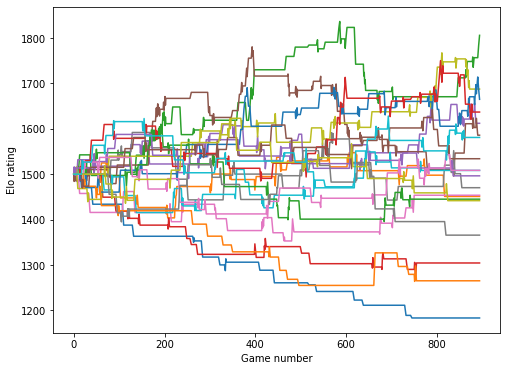

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(df_elo.loc[:, team_names])
plt.xlabel("Game number")
plt.ylabel("Elo rating")
plt.show()

Each line is the Elo rating of one team. They all start at 1500, and as games are played teams gain/lose Elo as they win/lose games. The fact that the spread of the ratings is still growing late in the season is an indication that we are limited in the amount of data we have.

We split the dataframe of Elo ratings into training and test sets with the same ratio as before, and make a model that always predicts that the team with a higher rating will win.

In [ ]:
elo_train = df_elo.iloc[:n_train, :].copy()
elo_test = df_elo.iloc[n_train:, :].copy()

In [ ]:
class LargerELOModel:
    """A model class that predicts the winner of a game to be the one that had a larger
    ELO rating.
    """

    def train(self, train_data):
        # All the necessary information has been computed already, there isn't any
        # training to do.
        pass

    def predict(self, predictors):
        """Predict the winner of each game to be the team with the higher ELO."""
        team1 = predictors["team_one_name"]
        team2 = predictors["team_two_name"]
        elo1 = predictors["team_one_elo"]
        elo2 = predictors["team_two_elo"]
        predictors["map_winner"] = team1.where(
            elo1 > elo2, other=team2.where(elo2 > elo1, other="draw")
        )
        return predictors

In [ ]:
train_and_test_bootstrap(elo_train, elo_test, LargerELOModel)

{'train rate': 0.6062639821029083,
 'test rate mean': 0.6238839285714286,
 'test rate std': 0.02519554424134051,
 'test rate 90th percentiles': array([0.59151786, 0.65848214]),
 'example model': <__main__.LargerELOModel at 0x7f92034a5820>}

This model clearly outperforms the earlier map win rate based model, reaching an accuracy roughly between 60% and 65%.

As an aside, we tried varying the k parameter for the Elo system, and couldn't find a value that would have significantly improved the accuracy we see here. We leave this analysis out of the story, for brevity.

## Combining Elo and map win rates

The Elo system is simple, elegant, and evidently quite powerful. However, it feels crude in how it entirely disregards all data about the maps: It's only concerned with who won against who. Perhaps we can improve on it by combining the Elo ratings with the map win rates, and use both for making our predictions? Let's try.

In [ ]:
def combine_elo_and_maprates(df_elo, df_maprates, team_names, map_names):
    team_map_pairs = list(itertools.product(team_names, map_names, ["wins", "losses"]))
    df_maprates = df_maprates[team_map_pairs + ["team_one_winrate", "team_two_winrate"]]
    df_elo_maprates = pd.concat(
        [df_elo, df_maprates],
        axis=1,
    )
    return df_elo_maprates

In [ ]:
def encode_map_winner(df):
    team1 = df["team_one_name"]
    team2 = df["team_two_name"]
    winner = df["map_winner"]
    N_games = len(team1)
    ones = pd.Series([1] * N_games)
    minus_ones = pd.Series([-1] * N_games)
    winner_number = ones.where(
        winner == team1, other=minus_ones.where(winner == team2, other=0)
    )
    return winner_number

In [ ]:
df_combined = combine_elo_and_maprates(df_elo, df_maprates, team_names, map_list)
df_combined["map_winner"] = encode_map_winner(df_combined)
prediction_columns = [
    "map_winner",
    "team_one_winrate",
    "team_two_winrate",
    "team_one_elo",
    "team_two_elo",
]
combined_train = df_combined.loc[:n_train, prediction_columns].copy()
combined_test = df_combined.loc[n_train : n_games - 1, prediction_columns].copy()

/usr/local/lib/python3.8/dist-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


We have combined the rolling Elo numbers and map win rates into a single dataframe. We have also encoded the outcomes of games numerically into a single column, so that `1` means team one won, `-1` means team two won, and `0` means the game was a draw. This allows using various statistical models meant for numerical rather than categorical data.

Previously we could simply predict that the team with the higher map win rate or higher Elo would win. Now that we use both as predictors, we have to decide how to combine them into a single prediction. Given how simple our predictors are, a natural starting point is a linear model, that models the numerically encoded (1,0, or -1) map winner as a linear combination of the win rates and the Elo scores of both teams. Note that this is the first time that any statistical modelling is happening in this story, and thus the first time that overfitting could in theory become a concern, and we need to actuall use trainining/test split we did in the beginning.

In [ ]:
class LinearClassifier:
    def __init__(self):
        self.model = linear_model.RidgeClassifier()

    def train(self, train_data):
        self.model.fit(
            train_data.drop(columns="map_winner"),
            train_data["map_winner"],
        )
        return None

    def predict(self, predictors):
        predictors["map_winner"] = self.model.predict(predictors)
        return predictors

In [ ]:
# Predict who wins using ELO and map win/loss information
train_and_test_bootstrap(combined_train, combined_test, LinearClassifier)

{'train rate': 0.6160714285714286,
 'test rate mean': 0.6215212527964207,
 'test rate std': 0.0232261313564008,
 'test rate 90th percentiles': array([0.5901566 , 0.64899329]),
 'example model': <__main__.LinearClassifier at 0x7f9203a78250>}

Combining the Elo and map win rates with a linear model yields a prediction accuracy somewhere around 60% to 65%. It is hard to say that this yields any improvement over only using the Elo data. This is somewhat disappointing; It seems our attempt at using more granular information than just plain Elo is of little help.

One could hypothesise that the issue is that our linear model is too crude and biased for this purpose. We did some experimentation around this, and it seems to not be the case: For instance some support vector machines perform no better.

# Part 7: Conclusions

We started with the question of whether we can predict outcomes of Overwatch games using data from earlier that same season. The answer seems to be "yes, to a limited extent".

After trying a simple win rate based model, we settled on using the Elo ratings system, which assigns a skill rating to each team based on who they win and lose against, rewarding more points for winning against highly ranked opponents. This got us to a range where we could correctly predict the outcomes of about 60-65% of the games in the last half of the season. That's substantially better than chance, but it's not overwhelmingly impressive. We hoped to improve on that by adding some map specific information, that would take into account some teams being especially good or bad on particular maps, but failed to improve the prediction accuracy significantly.

We of course can not know if some other model or way of doing the predictions would yield better results. However, from toying around with various methods, some of which we left out of the final story, the feeling we were left with is that we are probably close to what can be achieved with our current approach. To improve further we would either try modelling on a more granular scale of individual players, taking into account player transfers within a season, or find another angle of how to utilise map specific data. There is, of course, also a natural limit to how good our predictions can ever be, because there is inherent variation in how individual games go. We may or may not be close to that limit.

Overall, we were surprised by how general our analysis turned out to be: In the end the method that we got the most mileage out of were the Elo ratings, which can be applied to almost any game or sport. It's entirely blind to any particular features of Overwatch as a game. This is bad in that it leaves us with the feeling that we didn't understand anything very deep about Overwatch as a game through this analysis, but good in that our above code can be reused almost verbatim on other competitive games.

We wrote the bulk of this story in the middle of 2022 and thus ran our analysis on the 2021 season. By the time we were polishing the story for review the 2022 season had finished, so we ran the same analysis on that one too. It's very easy to do by simply changing the file to download and read data from in the very beginning, and we encourage the reader to do it. The main conclusions from 2022 are the same as above with 2021: Map win rate based predictions are still a bit better than chance but not much; Elo ratings yield better predictions than that, though nothing much above 60%; and combining Elo and map win rate isn't much better than just using Elo. The numbers do shift around a bit though, accuracies going up or down by a few percentage points.

The most interesting future exploration would be to move from the team-level to the player-level, and try to model the skill levels of the individuals that make up the teams. This would open whole new possibilities of using data from multiple seasons and tracking players across them as they may change teams. This would also enable us to for instance predict the performance of a rebuilt team at the beginning of a season based on who they've added to their roster, or model which teams seem to perform as more or less than the sum of their parts. That, though, is all work for another data story.

# END
## Below is old content to be discarded before formal review


## Visualising predictive power (To be deleted - most likely)

We can in fact study the predictive power of Elo ratings and win rates visually.

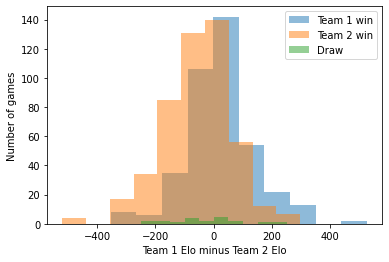

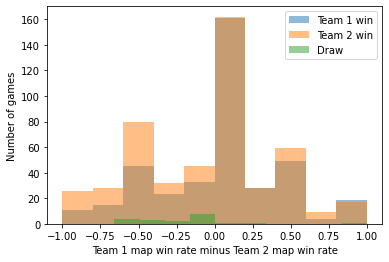

In [ ]:
def plot_elo_and_win_rate_hists(df_combined):
  df_plot = pd.DataFrame()
  df_plot["map_winner"] = df_combined["map_winner"].apply(lambda x: "Team 1 win" if x == 1 else "Team 2 win" if x == -1 else "Draw")
  df_plot["elo_diff"] = df_combined["team_one_elo"] - df_combined["team_two_elo"]
  df_plot["winrate_diff"] = df_combined["team_one_winrate"] - df_combined["team_two_winrate"]

  for result in df_plot["map_winner"].unique():
    tmp = df_plot[df_plot["map_winner"] == result]
    plt.hist(tmp["elo_diff"], alpha=0.5, label=result)
  plt.xlabel("Team 1 Elo minus Team 2 Elo")
  plt.ylabel("Number of games")
  plt.legend()
  plt.show()

  for result in df_plot["map_winner"].unique():
    tmp = df_plot[df_plot["map_winner"] == result]
    plt.hist(tmp["winrate_diff"], alpha=0.5, label=result)
  plt.xlabel("Team 1 map win rate minus Team 2 map win rate")
  plt.ylabel("Number of games")
  plt.legend()
  plt.show()

plot_elo_and_win_rate_hists(df_combined)

The first histogram shows how many games ended in a victory for team 1 (in blue), team 2 (orange), or tie (green), as a function of the difference in the two teams' Elo ratings. On the right of the plot are the games where team 1 had significantly higher Elo and they mostly ended in victories for team 1, conversely for team 2 and the left of the plot. One can easily see from this plot that Elo ratings should have some non-trivial predictive power for game outcomes.

The second histogram shows the same for map win rates. Games on the right are ones where, going into the game, team 1 had a much better past win rate on this map, conversely for team 2 and the left of the plot. Here the structure in the data, if any, is far less obvious. The most striking feature is the peak in the middle, for all the games where the two teams had equal win rates. This comes mostly from games where neither team had played that map before, which highlights our lack of data.

So do teams simply not specialise on different maps? We don't know. That might be, or it might be that we simply lack the data to see the effect of that specialisation. It might also be that there are better ways to make use of map specific data than what we've attempted here. For instance, perhaps we should, rather than using simply the percentage of games a team won on this map, compute some sort of map-specific skill score, like an Elo score. This will have to wait for a follow-up data story.

One possiblity we did explore, but that didn't make the cut into this story, was to see if using win rates for each team for different map _types_ (Assaul, Control, etc.) rather than individual maps would help our predictions. It was a somewhat useful predictor by itself, but provided no extra benefit when added on top of Elo ratings.

## Storyline planning:
(This is now out of date, but was our original plan)

1 - Introduction:
  Overwatch, how seasons work, how games work. Set the problem statement here.

2 - Let's just explore the data to see what's going on. What are the relevant pieces of data (columns)

3 - baseline predictors (optionals)
a) The pure guessing strategy
b) The win rate strategy

4) Elo model
What is elo
What is the success rate

(have we just lucked into this)

Resampling and variance (semi short)

varying the k in elo

5) We haven't used the fact that maps are different yet. Does map win rate make any difference? Do teams have any specialty

- map type winrates
- linear modelling
- throw in some random model to show its possible, and that it is not useful.

A useful predictor - but not very useful if we know elo already.

6) End, closing remarks - next steps 
- ties?



## Overwatch (probably to be deleted)

Overwatch is an online team-based multiplayer first-person shooter (FPS) game developed and published by Blizzard Entertainment. The game features several different game modes, principally designed around squad-based combat with two opposing teams of six players each. Matches consist of several games, which in turn may consist of several rounds. Each game is played on a particular map, with each map being of one of four map types.

There are 21 maps available for standard gameplay: 5 Assault maps, 6 Escort maps, 5 Hybrid maps, and 5 Control maps. 

- Assault maps have attacking and defending teams and once the round is complete, the roles are swapped. The attacking team must capture an objective while the defending team must protect it. 

- Escort maps have attacking and defending teams and once the round is complete, the roles are swapped. The attacking team must escort a payload across the map to an objective, while the defending team aims to stop them.

- Hybrid maps are a mixture of Assault and Escort maps and include attacking and defending teams. Once the round is complete, the roles are swapped. If the attacking team is able to capture the objective the game then becomes an escort situation.

- Control maps consist of three stages that are like smaller submaps that co-exist in one larger area. Unlike the other standard game modes, both teams are attackers. At the center of the stage is an area that the teams must capture and control. Control maps are by default symmetrical. Since the three stages are all very different from each other, Control maps offer the most variety in team compositions and strategies.

## Overwatch League (OWL) (probably to be deleted)

The Overwatch League (OWL) is the highest professional esports league for the video game Overwatch, and is owned and run by Blizzard Entertainment. The 2021 OWL featured four midseason tournaments throughout the regular season which used a point system for season playoff seeding. OWL 2021 consisted of 20 teams split into two geographical regions: North America (NA) and Asia (APAC).

Each match during the tournaments is a best of 5 (first to 3 wins) played over a map pool particular to the tournament. Each match follows the following order of game modes:
* Control
* Hybrid
* Escort
* Assault
* Control

The first control map is randomly selected, from that point on the losing team selects which map (restricted by game mode) is played next.